In [1]:
import numpy as np
import ast 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from gensim.models import Word2Vec 
from sklearn.preprocessing import normalize
from scipy.linalg import orthogonal_procrustes


### Aligning models for visualization 

In [2]:
#Load models 
LR_model = Word2Vec.load('Word2Vec models/LR_W2V_model') 
TP_model = Word2Vec.load('Word2Vec models/TP_W2V_model') 
LA_model = Word2Vec.load('Word2Vec models/LA_W2V_model')

#finding shared vocab 
shared_vocab = set(LR_model.wv.key_to_index.keys()).intersection(set(TP_model.wv.key_to_index.keys())).intersection(set(LA_model.wv.key_to_index.keys()))

#Extract embeddings and normalize 
LR_embeds = normalize([LR_model.wv[word] for word in shared_vocab])
TP_embeds = normalize([TP_model.wv[word] for word in shared_vocab])
LA_embeds = normalize([LA_model.wv[word] for word in shared_vocab]) 


In [3]:
# Align LR_model embeddings to TP_model embeddings 
matrix_solution_1, scale  = orthogonal_procrustes(LR_embeds, TP_embeds)
LR_aligned_embeddings = LR_embeds @ matrix_solution_1 

#Align LA_model embeddings to newly aligned LR_embeddings
matrix_solution_2, scale = orthogonal_procrustes(LA_embeds,LR_aligned_embeddings)
LA_aligned_embeddings = LA_embeds @ matrix_solution_2

In [4]:
# new word2vec 
aligned_LR_model = Word2Vec(vector_size=300) 
aligned_TP_model = Word2Vec(vector_size=300)
aligned_LA_model = Word2Vec(vector_size=300)

#assigning aligned embeddings to keys 
aligned_LR_model.wv.add_vectors(list(shared_vocab),LR_aligned_embeddings, replace=True)
aligned_TP_model.wv.add_vectors(list(shared_vocab),TP_embeds)
aligned_LA_model.wv.add_vectors(list(shared_vocab),LA_aligned_embeddings)

In [5]:
#example list of similar words
print(aligned_TP_model.wv.most_similar('iudex', topn=5))

[('iudicium', 0.3571789264678955), ('persona', 0.33455902338027954), ('iudico', 0.3236427307128906), ('reus', 0.3222998082637787), ('aduersarius', 0.30524444580078125)]


In [6]:
f = open('Standard Vocab testing list','r')
domain_vocab_list = ast.literal_eval(f.read())
civics_list = domain_vocab_list[0]
war_list = domain_vocab_list[1]

print("civ/religion: ",civics_list)
print("war: ",war_list)

civ/religion:  ['gens', 'amo', 'duo', 'uirtus', 'imperator', 'timeo', 'urbs', 'oppidum', 'grauis', 'rex', 'iubeo', 'ira', 'praesidium', 'paro', 'hostis', 'bellum', 'prouincia', 'reliquus', 'socius', 'mens', 'cohors', 'mitto', 'acies', 'miles', 'caesar', 'magnus', 'arma', 'manus', 'rapio', 'princeps', 'pompeius', 'romanus', 'locus', 'consilium', 'iter', 'nauis', 'proelium', 'cognosco', 'legatus', 'uinco', 'uotum', 'signum', 'proficiscor', 'uirgo', 'auxilium', 'pax', 'fortis', 'pugno', 'legio', 'ciuilis', 'populus', 'uictor', 'uir', 'relinquo', 'agmen', 'castra', 'imperium', 'eques', 'paucus', 'uis', 'tempus', 'copia', 'armo', 'dux', 'dies', 'capio', 'exercitus']
war:  ['deus', 'pater', 'permitto', 'uirtus', 'ciuis', 'ius', 'paulinus', 'augustinus', 'praetor', 'bonus', 'modus', 'iubeo', 'rogo', 'gero', 'christus', 'epistola', 'filius', 'liber', 'epistula', 'consul', 'bellum', 'uxor', 'hereditas', 'mitto', 'magnus', 'pietas', 'uenerabilis', 'seruus', 'princeps', 'sidonius', 'romanus', 'un

### T-SNE Visualization

In [7]:
def tsne_embeddings(word,num_nn): 
    labels = []
    embeds = []
    period = []

    #vector for target at LR
    labels.append(word+'_LR')
    embeds.append(aligned_LR_model.wv.get_vector(word))
    period.append('green')
    
    #vector for target at TP
    labels.append(word+'_TP')
    embeds.append(aligned_TP_model.wv.get_vector(word))
    period.append('green')

    #vector for target at LA
    labels.append(word+'_LA')
    embeds.append(aligned_LA_model.wv.get_vector(word))
    period.append('green')

    for w, _ in list(aligned_LR_model.wv.most_similar(word, topn=num_nn)):
        labels.append(w)
        embeds.append(aligned_LR_model.wv.get_vector(w))
        period.append('red')

    for w, _ in list(aligned_TP_model.wv.most_similar(word, topn=num_nn)):
      if w not in labels:   
        labels.append(w)
        embeds.append(aligned_TP_model.wv.get_vector(w))
        period.append('purple')

    for w, _ in list(aligned_LA_model.wv.most_similar(word, topn=num_nn)):
        if w not in labels: 
            labels.append(w)
            embeds.append(aligned_LA_model.wv.get_vector(w))
            period.append('blue')

    embeds = np.array(embeds)

    tsne_model = TSNE(perplexity=5, n_components=2, verbose=1, learning_rate=10, random_state = 10, max_iter = 1000)
    values = tsne_model.fit_transform(embeds)
   
    return labels,values,period

In [8]:
def visualizations(tsne): 
    l = tsne[0]
    v = tsne[1]
    p = tsne[2]

    #visualization for LR to TP
    l_1 = []
    v_1 = []
    p_1 = []

    for i in range(len(p)): 
        if p[i] == 'red' or p[i] == 'purple' or p[i] == 'green': 
            l_1.append(l[i])
            v_1.append(v[i])
            p_1.append(p[i])

    v_1 =  np.array(v_1)


    plt.figure(figsize=(10, 8))
    plt.scatter(v_1[:, 0],v_1[:, 1], c=p_1)
    plt.title('T-SNE Visualization for LR to TP')
    plt.xlabel('t-SNE X Dimension')
    plt.ylabel('t-SNE Y Dimension')


    for i, label in enumerate(l_1):
        plt.annotate(label, (v_1[i, 0], v_1[i, 1]))

    plt.show()

    #visualization for TP to LA
    l_2 = []
    v_2 = []
    p_2 = []

    for i in range(len(p)): 
        if p[i] == 'purple' or p[i] == 'blue' or p[i] == 'green': 
            l_2.append(l[i])
            v_2.append(v[i])
            p_2.append(p[i])

    v_2 =  np.array(v_2)


    plt.figure(figsize=(10, 8))
    plt.scatter(v_2[:, 0],v_2[:, 1], c=p_2)
    plt.title('T-SNE Visualization for TP to LA')
    plt.xlabel('t-SNE X Dimension')
    plt.ylabel('t-SNE Y Dimension')


    for i, label in enumerate(l_2):
        plt.annotate(label, (v_2[i, 0], v_2[i, 1]))

    plt.show()

    #visualization for All Periods
    plt.figure(figsize=(10, 8))
    plt.scatter(v[:, 0], v[:, 1], c=p)
    plt.title('T-SNE Visualization of All periods')
    plt.xlabel('t-SNE X Dimension')
    plt.ylabel('t-SNE Y Dimension')


    for i, label in enumerate(l):
        plt.annotate(label, (v[i, 0], v[i, 1]))

    plt.show()


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 42 samples in 0.000s...
[t-SNE] Computed neighbors for 42 samples in 0.088s...
[t-SNE] Computed conditional probabilities for sample 42 / 42
[t-SNE] Mean sigma: 0.253309
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.437958
[t-SNE] KL divergence after 1000 iterations: 0.724480


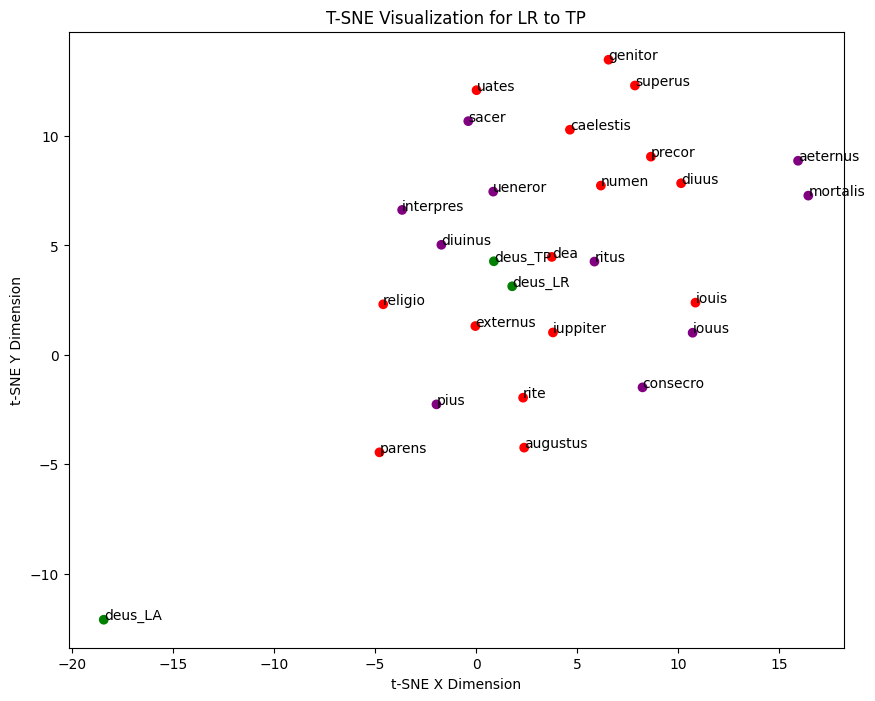

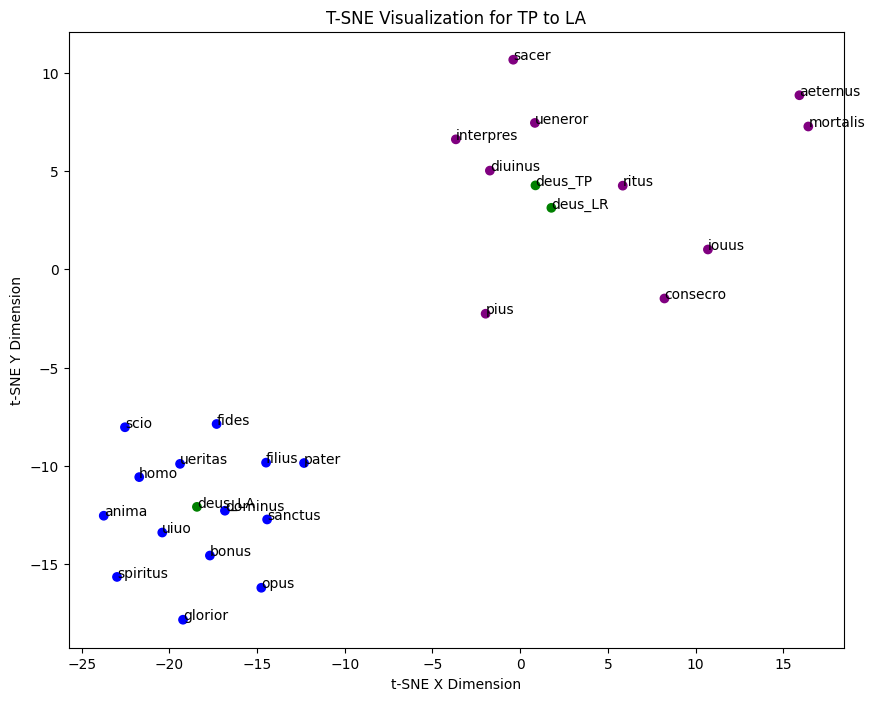

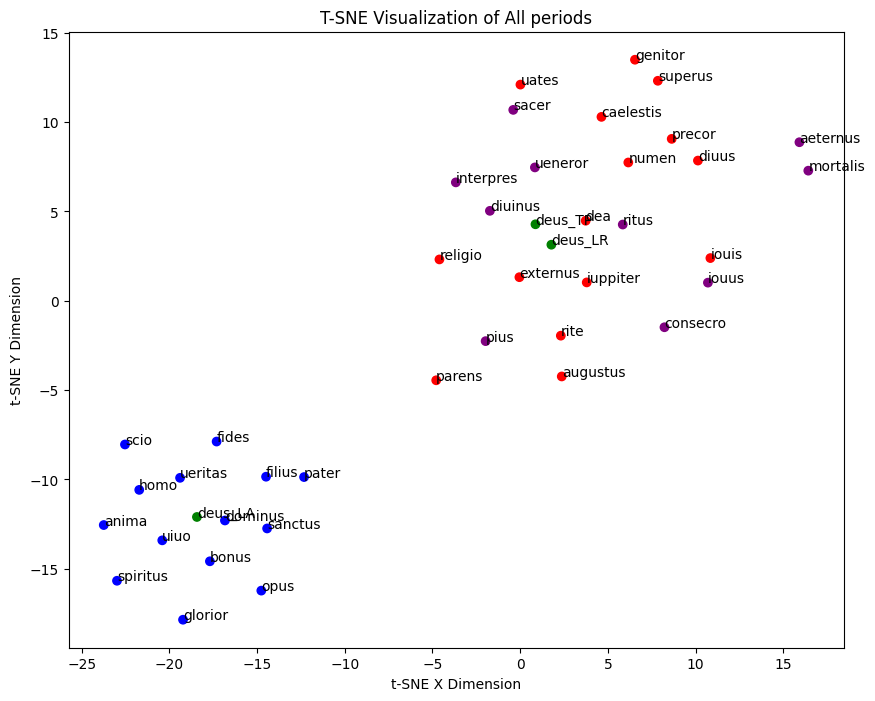

In [9]:
visualizations(tsne_embeddings('deus',15))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 46 samples in 0.000s...
[t-SNE] Computed neighbors for 46 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 46 / 46
[t-SNE] Mean sigma: 0.243752
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.416306
[t-SNE] KL divergence after 1000 iterations: 0.866338


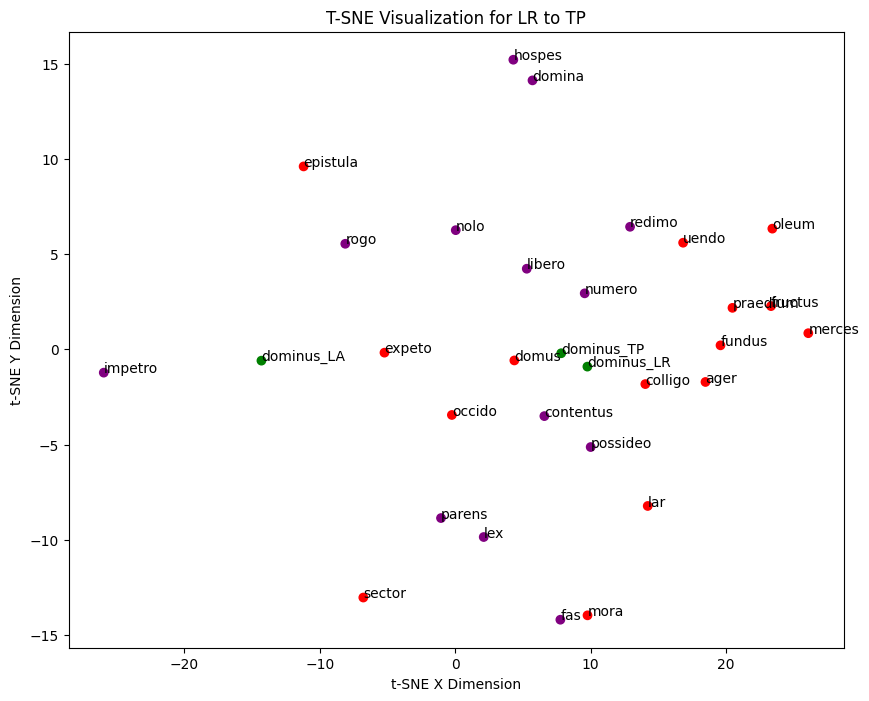

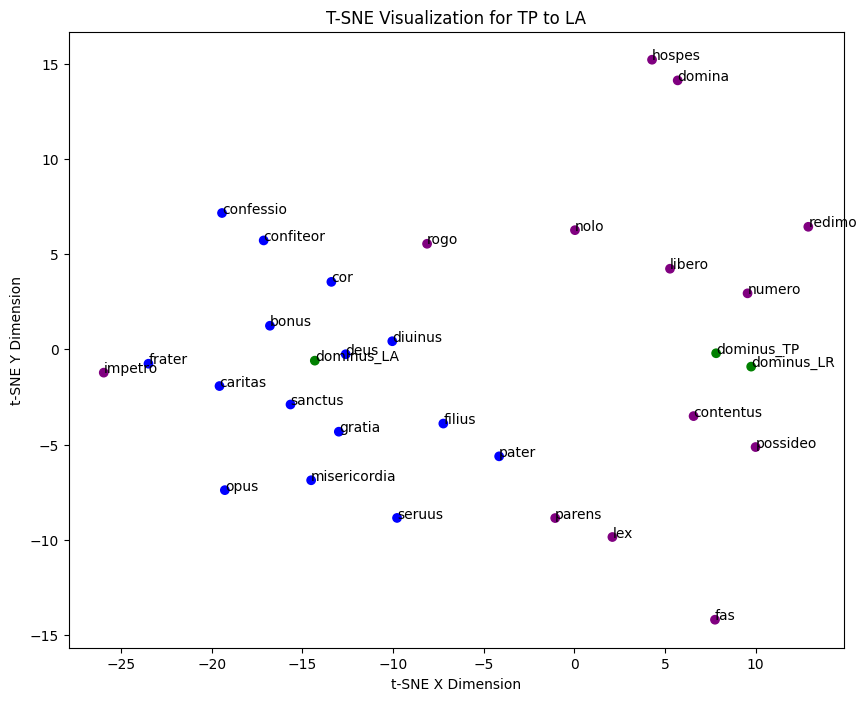

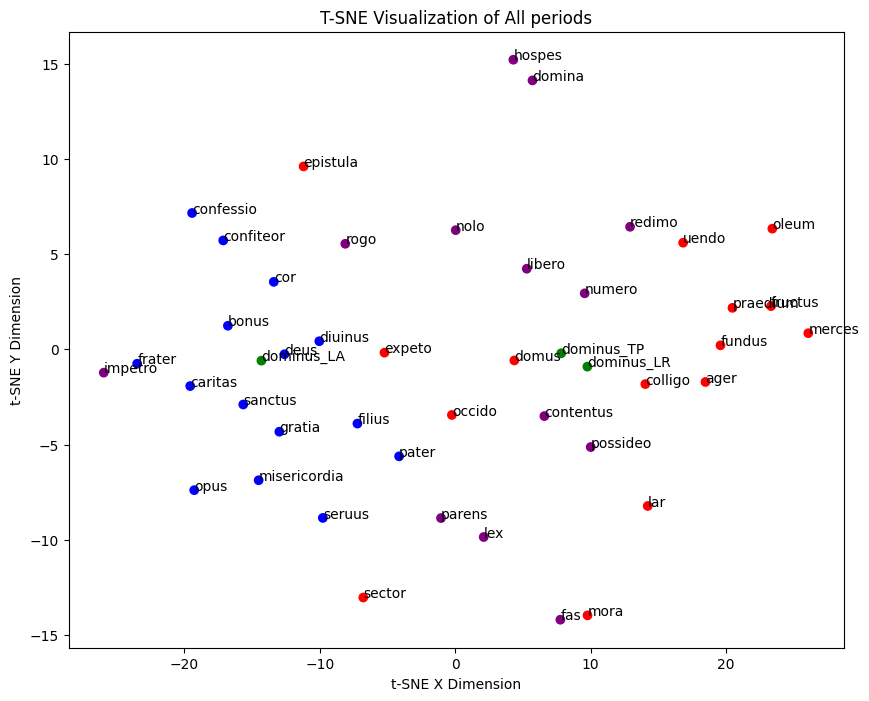

In [10]:
visualizations(tsne_embeddings('dominus',15))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 41 samples in 0.001s...
[t-SNE] Computed neighbors for 41 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 41 / 41
[t-SNE] Mean sigma: 0.244682
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.550072
[t-SNE] KL divergence after 1000 iterations: 0.654792


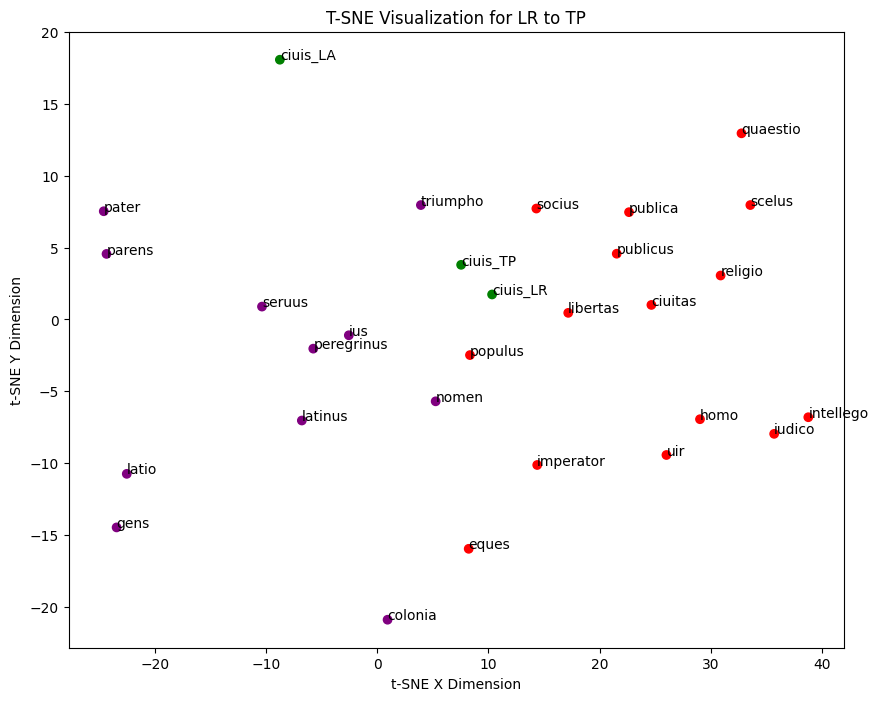

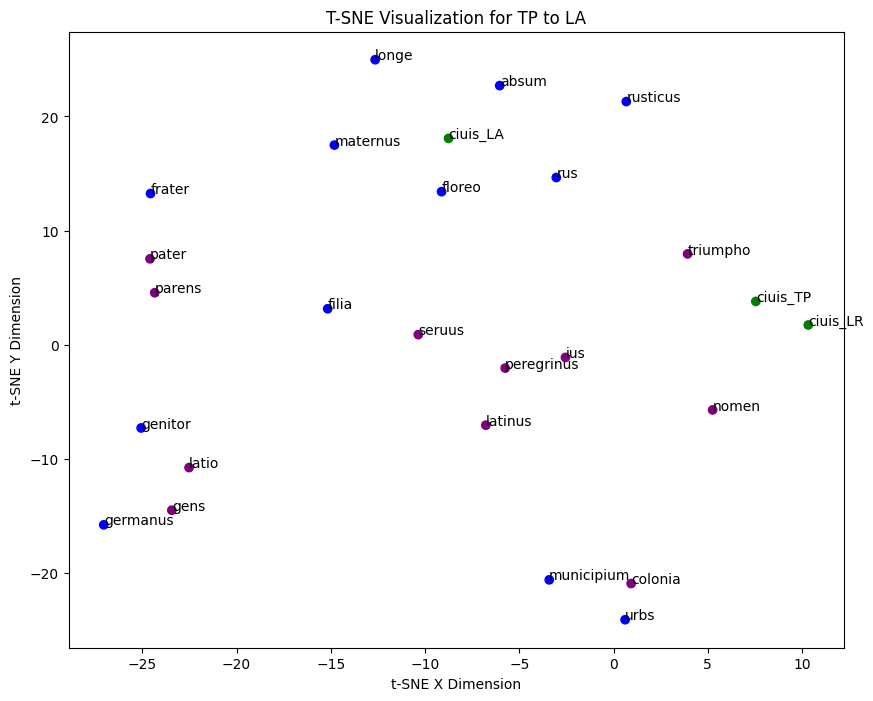

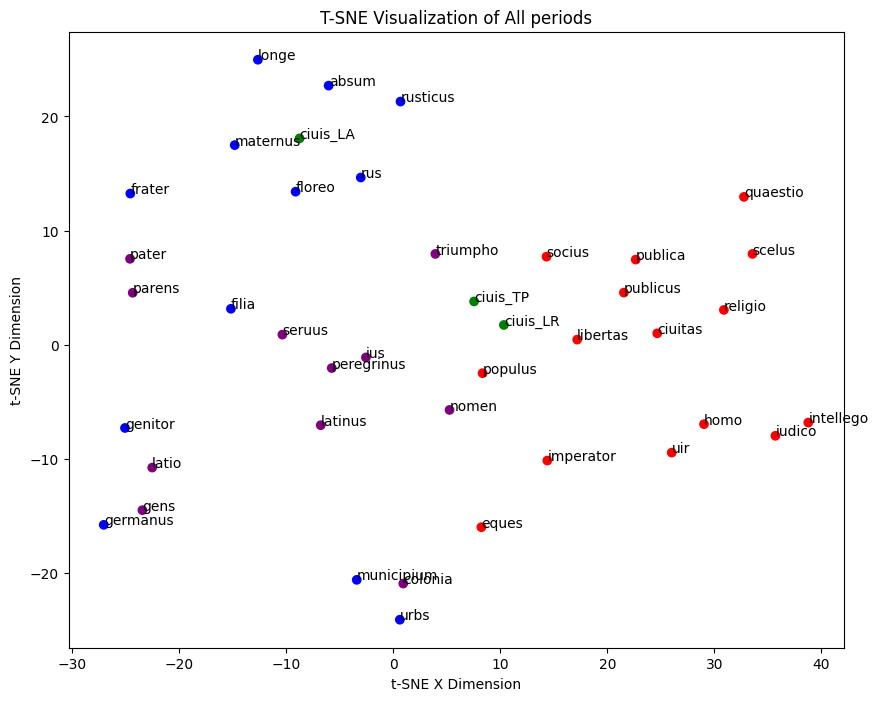

In [11]:
visualizations(tsne_embeddings('ciuis',15))